In [88]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

In [2]:
df_ids = nfl.import_ids()
df_weekly = nfl.import_weekly_data(range(2018, 2025))
df_seasonal = nfl.import_seasonal_data(range(2018,2025))
df_schedule = nfl.import_schedules(range(2018, 2025))
df_pass_pfr = nfl.import_weekly_pfr('pass', range(2018, 2025))
df_rush_pfr = nfl.import_weekly_pfr('rush', range(2018, 2025))
df_rec_pfr = nfl.import_weekly_pfr('rec', range(2018, 2025))
df_pass_ngs = nfl.import_ngs_data('passing',range(2018, 2025))
df_rush_ngs = nfl.import_ngs_data('rushing',range(2018, 2025))
df_rec_ngs = nfl.import_ngs_data('receiving',range(2018, 2025))
df_snap_counts = nfl.import_snap_counts(range(2018, 2025))

Downcasting floats.


In [3]:
# 
df_weekly = df_weekly[(df_weekly['season_type'] == 'REG') & (df_weekly['position'].isin(['QB', 'WR', 'RB', 'TE']))]

# 
df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']

# Rename player_id's to later merge using the consistent player_id
df_ids = df_ids.rename(columns={'gsis_id': 'player_id', 'pfr_id': 'pfr_player_id'})
df_pass_ngs = df_pass_ngs.rename(columns={'player_gsis_id': 'player_id'})
df_rush_ngs = df_rush_ngs.rename(columns={'player_gsis_id': 'player_id'})
df_rec_ngs = df_rec_ngs.rename(columns={'player_gsis_id': 'player_id'})

df_merged = pd.melt(
    df_weekly,
    id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'sacks', 'sack_yards', 'passing_air_yards', 'passing_epa', 'pacr', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'rushing_epa', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'racr', 'wopr', 'receiving_epa', 'fantasy_points'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id'
)

In [4]:
df_merged = pd.merge(df_merged, df_ids[['player_id', 'pfr_player_id', 'draft_pick', 'draft_year']], on = 'player_id', how = 'inner')
df_merged = pd.merge(df_merged, df_seasonal[['player_id', 'season', 'dom']], on = ['player_id', 'season'], how = 'left')
df_merged = pd.merge(df_merged, df_schedule[['game_id', 'home_team']], on='game_id', how='inner')
df_merged = pd.merge(df_merged, df_pass_pfr[['pfr_player_id', 'season', 'week', 'passing_bad_throws', 'times_pressured']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rec_pfr[['pfr_player_id', 'season', 'week', 'receiving_rat']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rush_pfr[['pfr_player_id', 'season', 'week', 'rushing_broken_tackles']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_pass_ngs[['player_id', 'season', 'week', 'passer_rating', 'aggressiveness']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rec_ngs[['player_id', 'season', 'week', 'catch_percentage']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_rush_ngs[['player_id', 'season', 'week', 'efficiency']], on = ['player_id', 'season', 'week'], how = 'left')
df_merged = pd.merge(df_merged, df_snap_counts[['pfr_player_id', 'season', 'week', 'offense_snaps']], on = ['pfr_player_id', 'season', 'week'], how = 'left')

df_merged = df_merged.drop(columns=['game_id', 'game_id_type', 'pfr_player_id'])

In [5]:
df_merged = df_merged.fillna(0)

df_merged['rookie_flag'] = (df_merged['season'] == df_merged['draft_year']).astype(int)
df_merged['last_season_data_flag'] = (df_merged['week'] < 6).astype(int)

recent_team_means = df_merged.groupby(['recent_team', 'season', 'week'])['fantasy_points'].mean().reset_index()
opponent_team_means = df_merged.groupby(['opponent_team', 'season', 'week'])['fantasy_points'].mean().reset_index()
position_means = df_merged.groupby(['position', 'season', 'week'])['fantasy_points'].mean().reset_index()

recent_team_means.rename(columns={'fantasy_points': 'recent_team_encoded'}, inplace=True)
opponent_team_means.rename(columns={'fantasy_points': 'opponent_team_encoded'}, inplace=True)
position_means.rename(columns={'fantasy_points': 'position_encoded'}, inplace=True)

df_merged = pd.merge(df_merged, recent_team_means, on=['recent_team', 'season', 'week'], how='left')
df_merged = pd.merge(df_merged, opponent_team_means, on=['opponent_team', 'season', 'week'], how='left')
df_merged = pd.merge(df_merged, position_means, on=['position', 'season', 'week'], how='left')


df_merged['turnover'] = (
    df_merged['interceptions'] +
    df_merged['sack_fumbles_lost'] +
    df_merged['rushing_fumbles_lost'] +
    df_merged['receiving_fumbles_lost']
)

# calculating fantasy points scored by category
df_merged['rushing_pts'] = (df_merged['rushing_tds'] * 6) + (df_merged['rushing_2pt_conversions'] * 2)
df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)
df_merged['passing_pts'] = (df_merged['passing_tds'] * 6) + (df_merged['passing_2pt_conversions'] * 2)

df_merged['epa_total'] = df_merged['passing_epa'] + df_merged['rushing_epa'] + df_merged['receiving_epa']

# Dropping features that were integrated into other features above
df_merged = df_merged.drop(columns=['draft_year', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 
                                    'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 
                                    'passing_2pt_conversions', 'passing_epa', 'rushing_epa', 'receiving_epa'])

# features for whom rolling features should be created
columns_to_roll = ['completions', 'attempts', 'passing_yards', 'sacks', 'passer_rating', 'aggressiveness', 'catch_percentage', 'efficiency',
                   'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'offense_snaps', 'recent_team_encoded', 'opponent_team_encoded', 
                   'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'fantasy_points', 'passing_bad_throws', 
                   'times_pressured', 'position_encoded', 'epa_total', 'receiving_rat', 'rushing_broken_tackles', 'turnover', 'rushing_pts', 
                   'receiving_pts', 'passing_pts']

In [6]:
def create_rolling_features(df, columns_to_roll):
    # Sort dataframe
    df = df.sort_values(['player_id', 'season', 'week']).reset_index(drop=True)
    
    # Create empty dictionary to store all new features
    new_features = {}
    
    for col in columns_to_roll:
        # 5-week window stats
        grouped = df.groupby('player_id')[col].shift(1)
        
        new_features[f'ewm_{col}_l5w'] = (grouped
            .ewm(span=5, min_periods=5)
            .mean())
        
        for metric in ['mean', 'median', 'std']:
            new_features[f'{metric}_{col}_l5w'] = (grouped
                .rolling(window=5, min_periods=5)
                .agg(metric))
        
        # 3-week window stats
        for metric in ['max', 'min']:
            new_features[f'{metric}_{col}_l3w'] = (grouped
                .rolling(window=3, min_periods=3)
                .agg(metric))
    
    # Add fantasy points feature
    new_features['cnt_games_over_20ffpts_l5w'] = (
        df.groupby('player_id')['fantasy_points']
        .shift(1)
        .rolling(window=5, min_periods=5)
        .apply(lambda x: (x > 20).sum())
    )
    
    # Combine all new features at once
    feature_df = pd.DataFrame(new_features)
    
    # Combine with original dataframe
    return pd.concat([df, feature_df], axis=1)

In [7]:
# Anwendung auf df_merged
df_merged = create_rolling_features(df_merged, columns_to_roll)

In [8]:
df_merged = df_merged.dropna()

df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards',  
                                    'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 
                                    'wopr', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'turnover', 
                                    'rushing_pts', 'receiving_pts', 'passing_pts', 'home_team', 'passer_rating', 'aggressiveness',
                                    'catch_percentage', 'efficiency', 'offense_snaps', 'recent_team_encoded', 'opponent_team_encoded', 
                                    'position_encoded', 'recent_team', 'opponent_team', 'position', 'epa_total'])

In [9]:
df_merged = df_merged.sort_values(['player_id', 'season', 'week'])
df_merged['did_play'] = 1

player_seasons = df_merged[['player_id', 'season']].drop_duplicates()

all_weeks = []

for _, row in player_seasons.iterrows():
    # Assuming weeks go from 1 to 18 for NFL season
    weeks = pd.DataFrame({
        'player_id': row['player_id'],
        'season': row['season'],
        'week': range(1, 19),
    })
    all_weeks.append(weeks)
    
complete_weeks = pd.concat(all_weeks, ignore_index=True)

df_merged = pd.merge(
    complete_weeks,
    df_merged,
    on=['player_id', 'season', 'week'],
    how='left'
)

df_merged = df_merged.fillna(0)

In [10]:
df_seq = df_merged.copy()

df_seq['time_index'] = df_seq['season'] * 100 + df_seq['week']

df_seq = df_seq.sort_values(['player_id', 'time_index'])

In [11]:
df_predict = df_seq[df_seq['time_index'] > 202318]
df_train = df_seq[df_seq['time_index'] < 202401]

In [69]:
# 1. Data Preparation
def prepare_data(df):
    # Sort data chronologically
    df = df.sort_values(['player_id', 'season', 'week'])
    
    # Encode player_id
    le = LabelEncoder()
    player_id_encoded = le.fit_transform(df['player_id']).reshape(-1, 1)
    
    # Split features and target
    features = df.drop(['fantasy_points', 'player_id', 'week', 'season'], axis=1)
    target = df['fantasy_points']
    
    # Scale numeric features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Combine encoded player_id with scaled features
    final_features = np.hstack([player_id_encoded, scaled_features])
    
    # Create column names for final features
    feature_names = ['player_id_encoded'] + list(features.columns)
    
    # Convert to DataFrame to preserve column names
    final_df = pd.DataFrame(
        final_features,
        columns=feature_names,
        index=df.index
    )
    
    return final_df.values, target.values, scaler, le

# 2. Sequence Creation
def create_sequences(data, target, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# 3. Model Architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Training Process
# Prepare data
scaled_features, target, scaler, le = prepare_data(df_train)
X, y = create_sequences(scaled_features, target)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create and train model
model = create_model((X.shape[1], X.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 5. Evaluation
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

c:\Users\JOELA\python_projects\ff_data_science\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 31.4900 - val_loss: 28.3493
Epoch 2/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 28.7736 - val_loss: 25.1640
Epoch 3/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 28.1215 - val_loss: 25.4565
Epoch 4/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 27.5233 - val_loss: 28.7836
Epoch 5/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 27.2162 - val_loss: 28.1187
Epoch 6/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 27.1454 - val_loss: 24.9016
Epoch 7/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 26.5762 - val_loss: 27.7688
Epoch 8/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 25.8705 - val_loss: 24.6781
Epoch 9/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 26.6153 - val_loss: 26.5737
Epoch 10/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 26.8366 - val_loss: 25.0558
Epoch 11/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 26.1613 - val_loss: 25.4635
Epoch 12/50
990/990 ━━━━━━━━━

In [70]:
def analyze_model_performance(history):
    """
    Analyze and visualize model training performance with focus on loss
    Args:
        history: History object returned from model.fit()
    """
    import matplotlib.pyplot as plt
    
    # Create single plot for loss
    plt.figure(figsize=(10, 6))
    
    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary metrics
    print("\nTraining Performance Summary:")
    print("-" * 30)
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    
    if 'val_loss' in history.history:
        print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [78]:
print("Model input shape:", model.input_shape)
print("X shape:", X.shape)

Model input shape: (None, 4, 200)
X shape: (49496, 4, 200)


In [77]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 4, 128)         │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 4, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,245 (2.65 MB)

 Trainable params: 231,265 (903.38 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 462,532 (1.76 MB)

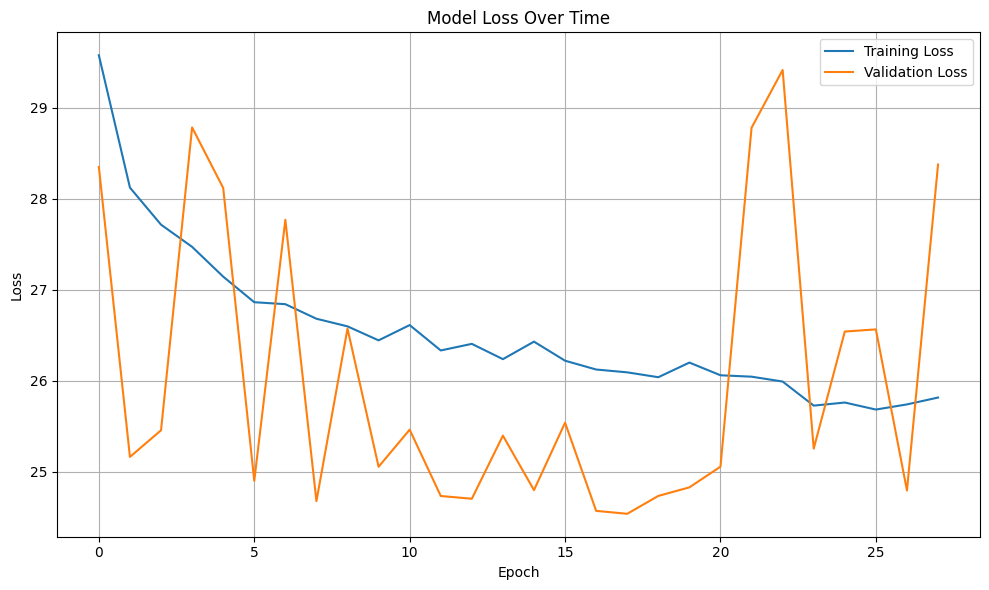


Training Performance Summary:
------------------------------
Final Training Loss: 25.8162
Final Validation Loss: 28.3760


In [71]:
# Usage example:
analyze_model_performance(history)

In [83]:
def prepare_sequence_data(df_seq):
    """
    Prepare all data (2018-2024) for sequence prediction
    """
    # Sort chronologically
    df_sorted = df_seq.sort_values(['player_id', 'season', 'week'])
    
    # Encode player_ids
    le = LabelEncoder()
    player_id_encoded = le.fit_transform(df_sorted['player_id']).reshape(-1, 1)
    
    # Scale features
    features = df_sorted.drop(['fantasy_points', 'player_id', 'week', 'season'], axis=1)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Combine encoded IDs with scaled features
    final_features = np.hstack([player_id_encoded, scaled_features])
    
    # Create final DataFrame with metadata
    feature_names = ['player_id_encoded'] + list(features.columns)
    prepared_df = pd.DataFrame(
        final_features,
        columns=feature_names,
        index=df_sorted.index
    )
    
    # Add back metadata columns
    prepared_df['original_player_id'] = df_sorted['player_id']
    prepared_df['season'] = df_sorted['season']
    prepared_df['week'] = df_sorted['week']
    prepared_df['fantasy_points'] = df_sorted['fantasy_points']
    
    return prepared_df, scaler, le

def predict_2024_season(model, prepared_df, scaler, le, sequence_length=6):
    """
    Predict 2024 season using prepared data
    """
    predictions = []
    
    # Get 2024 weeks
    weeks_2024 = sorted(prepared_df[prepared_df['season'] == 2024]['week'].unique())
    
    for week in weeks_2024:
        # Get active players in current week
        current_players = prepared_df[
            (prepared_df['season'] == 2024) & 
            (prepared_df['week'] == week)
        ]['original_player_id'].unique()
        
        for player in current_players:
            # Get historical sequence
            player_history = prepared_df[
                (prepared_df['original_player_id'] == player) & 
                ((prepared_df['season'] < 2024) | 
                 ((prepared_df['season'] == 2024) & (prepared_df['week'] < week)))
            ].tail(sequence_length-1)
            
            if len(player_history) < sequence_length-1:
                continue
                
            # Get current week features
            current_week = prepared_df[
                (prepared_df['original_player_id'] == player) & 
                (prepared_df['season'] == 2024) & 
                (prepared_df['week'] == week)
            ]
            
            # Combine sequence
            sequence = pd.concat([player_history, current_week])
            sequence_features = sequence.drop(['original_player_id', 'season', 'week', 'fantasy_points'], axis=1)
            
            # Reshape for LSTM
            X = sequence_features.values.reshape(1, sequence_length, sequence_features.shape[1])
            
            # Predict
            pred = model.predict(X, verbose=0)
            
            # Store prediction
            predictions.append({
                'player_id': player,
                'week': week,
                'predicted_fantasy_points': float(pred[0][0])
            })
    
    return pd.DataFrame(predictions)

In [84]:
# Prepare data
prepared_df, scaler, le = prepare_sequence_data(df_seq)

# Make predictions
predictions_2024 = predict_2024_season(model, prepared_df, scaler, le)

In [85]:
predictions_2024.head()

,player_id,week,predicted_fantasy_points
0,00-0023459,1,5.369044
1,00-0024243,1,0.800699
2,00-0026158,1,2.469236
3,00-0026300,1,0.883849
4,00-0026498,1,14.706696


In [90]:
def analyze_2024_predictions(predictions_df, df_seq):
    """
    Analyze prediction performance for 2024 season
    """
    # Print column names for debugging
    print("Before merge columns:")
    print("Predictions columns:", predictions_df.columns)
    print("df_seq columns:", df_seq.columns)
    
    # Merge predictions with actuals
    analysis_df = predictions_df.merge(
        df_seq[df_seq['season'] == 2024][['player_id', 'week', 'fantasy_points']],
        on=['player_id', 'week']
    )
    
    print("\nAfter merge columns:")
    print(analysis_df.columns)
    
    # Calculate metrics
    mae = mean_absolute_error(analysis_df['fantasy_points'], 
                            analysis_df['predicted_fantasy_points'])
    mse = mean_squared_error(analysis_df['fantasy_points'], 
                           analysis_df['predicted_fantasy_points'])
    r2 = r2_score(analysis_df['fantasy_points'], 
                  analysis_df['predicted_fantasy_points'])
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(analysis_df['fantasy_points'], 
               analysis_df['predicted_fantasy_points'], 
               alpha=0.5)
    plt.plot([0, max(analysis_df['fantasy_points'])], 
             [0, max(analysis_df['fantasy_points'])], 
             'r--')
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Predicted vs Actual Fantasy Points')
    
    # 2. Error distribution
    plt.subplot(2, 2, 2)
    errors = analysis_df['predicted_fantasy_points'] - analysis_df['fantasy_points']
    plt.hist(errors, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    
    # 3. Weekly average error
    plt.subplot(2, 2, 3)
    weekly_mae = analysis_df.groupby('week').apply(
        lambda x: mean_absolute_error(x['fantasy_points'], 
                                    x['predicted_fantasy_points'])
    )
    weekly_mae.plot(kind='bar')
    plt.xlabel('Week')
    plt.ylabel('Mean Absolute Error')
    plt.title('Weekly Prediction Error')
    
    # 4. Top/Bottom Players
    plt.subplot(2, 2, 4)
    player_mae = analysis_df.groupby('player_id').apply(
        lambda x: mean_absolute_error(x['fantasy_points'], 
                                    x['predicted_fantasy_points'])
    )
    top_bottom = pd.concat([player_mae.nsmallest(5), player_mae.nlargest(5)])
    top_bottom.plot(kind='bar')
    plt.xlabel('Player ID')
    plt.ylabel('Mean Absolute Error')
    plt.title('Best/Worst Predicted Players')
    
    plt.tight_layout()
    
    print(f"\nMean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    return analysis_df

Before merge columns:
Predictions columns: Index(['player_id', 'week', 'predicted_fantasy_points'], dtype='object')
df_seq columns: Index(['player_id', 'season', 'week', 'fantasy_points', 'draft_pick', 'dom',
       'rookie_flag', 'last_season_data_flag', 'ewm_completions_l5w',
       'mean_completions_l5w',
       ...
       'min_receiving_pts_l3w', 'ewm_passing_pts_l5w', 'mean_passing_pts_l5w',
       'median_passing_pts_l5w', 'std_passing_pts_l5w', 'max_passing_pts_l3w',
       'min_passing_pts_l3w', 'cnt_games_over_20ffpts_l5w', 'did_play',
       'time_index'],
      dtype='object', length=203)

After merge columns:
Index(['player_id', 'week', 'predicted_fantasy_points', 'fantasy_points'], dtype='object')


C:\Users\JOELA\AppData\Local\Temp\ipykernel_16500\788993893.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_mae = analysis_df.groupby('week').apply(
C:\Users\JOELA\AppData\Local\Temp\ipykernel_16500\788993893.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_mae = analysis_df.groupby('player_id').apply(



Mean Absolute Error: 2.90
Mean Squared Error: 21.59
R-squared Score: 0.47


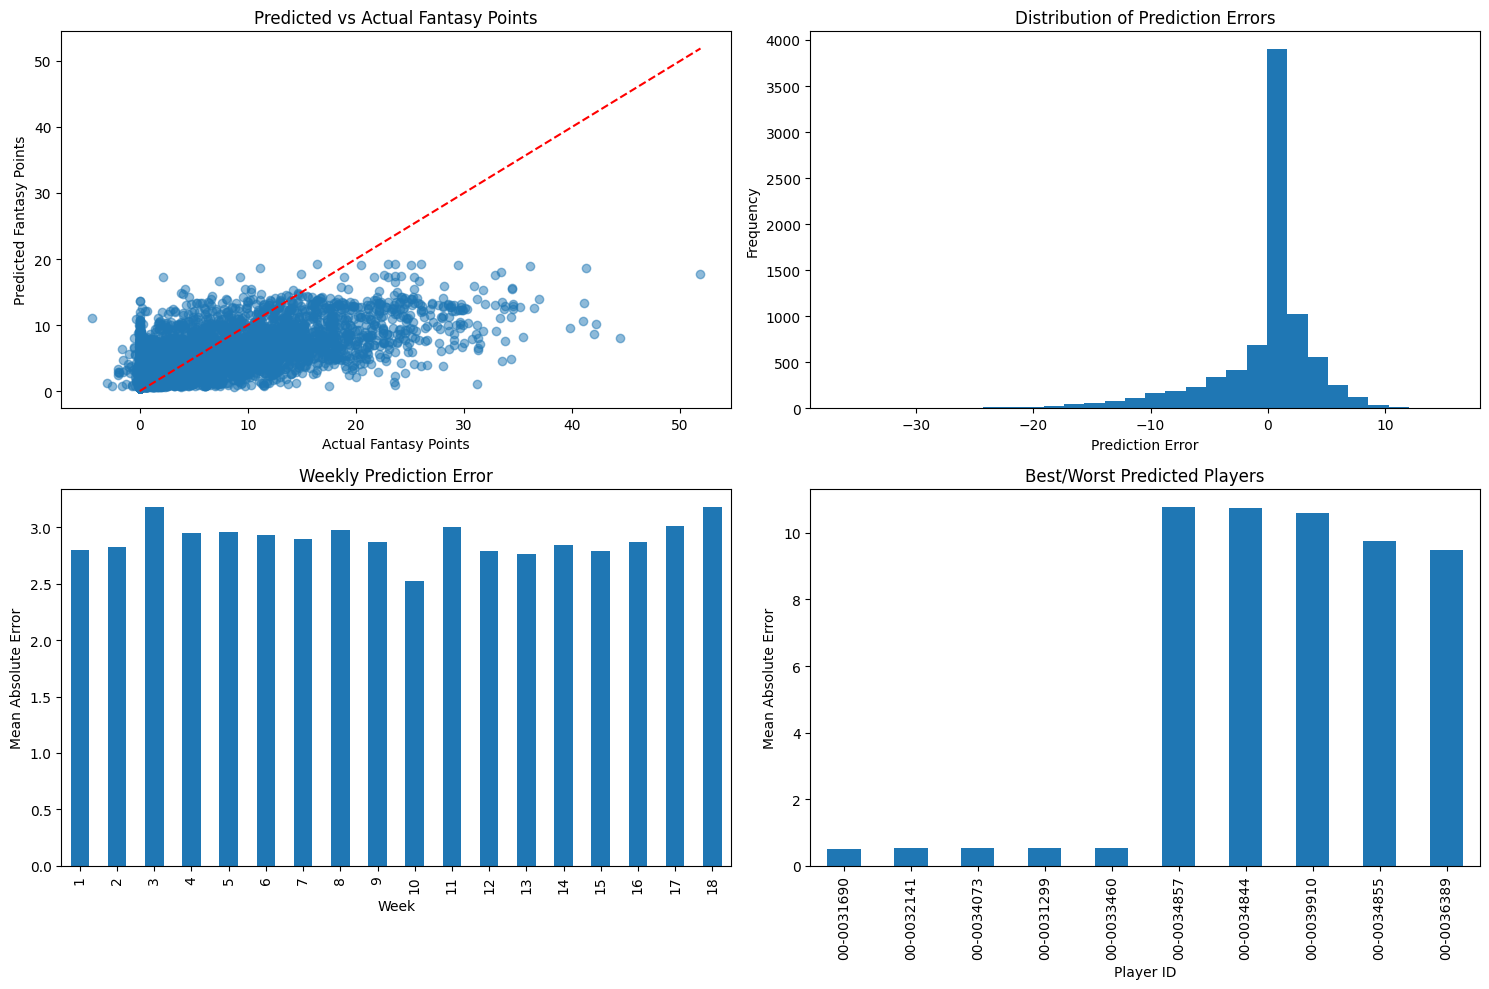

In [91]:
analysis_results = analyze_2024_predictions(predictions_2024, df_seq)
plt.show()

In [94]:
def analyze_feature_importance(model, X_test, y_test, feature_names, scaler, sequence_length=4):
    """
    Analyze and visualize feature importance using multiple methods
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 1. Create baseline predictions
    baseline_preds = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # 2. Feature Importance through Permutation
    importances = []
    importances_std = []
    
    for i in range(X_test.shape[2]):  # iterate through features
        X_test_temp = X_test.copy()
        
        # Permute the i-th feature
        X_test_temp[:,:,i] = np.random.permutation(X_test_temp[:,:,i])
        
        # Get predictions with permuted feature
        perm_preds = model.predict(X_test_temp, verbose=0)
        perm_mse = mean_squared_error(y_test, perm_preds)
        
        # Calculate importance
        importance = perm_mse - baseline_mse
        importances.append(importance)
    
    # Create DataFrame of importances
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Visualizations
    plt.figure(figsize=(12, 6))
    
    # Plot feature importances
    plt.subplot(1, 1, 1)
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Importance (Increase in MSE when feature is permuted)')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    return importance_df

schon hier
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


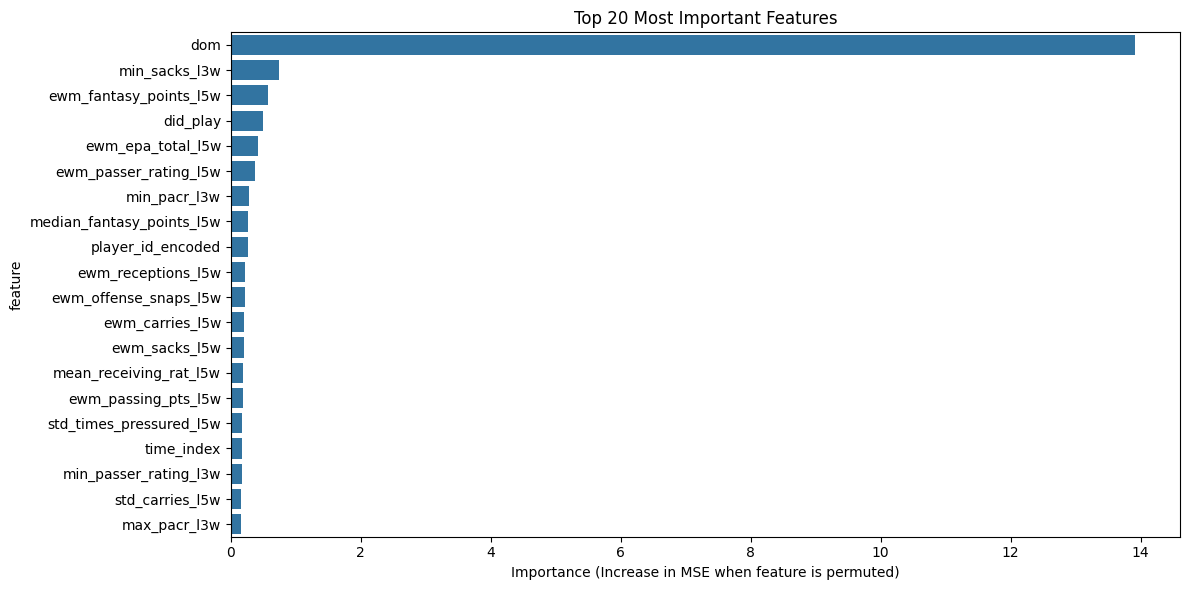


Top 10 Most Important Features:
                       feature  importance
2                          dom   13.911997
28               min_sacks_l3w    0.738581
131     ewm_fantasy_points_l5w    0.576292
198                   did_play    0.492792
155          ewm_epa_total_l5w    0.420563
29       ewm_passer_rating_l5w    0.365644
70                min_pacr_l3w    0.281399
133  median_fantasy_points_l5w    0.264896
0            player_id_encoded    0.263073
101         ewm_receptions_l5w    0.217871


In [96]:
# First get feature names from your prepare_data function
_, _, scaler, le = prepare_data(df_train)  # your existing prepare_data call
features = df_train.drop(['fantasy_points', 'player_id', 'week', 'season'], axis=1).columns.tolist()
feature_names = ['player_id_encoded'] + features

print("schon hier")

# Now analyze feature importance
importance_results = analyze_feature_importance(model, X_test, y_test, feature_names, scaler)

In [132]:
import os

current_dir = os.getcwd()
print("current_dir" + current_dir)
parent_dir = os.path.dirname(current_dir)
print("parent_dir" + parent_dir)
models_path = os.path.join(parent_dir, 'models')

current_dirc:\Users\JOELA\python_projects\ff_data_science\src
parent_dirc:\Users\JOELA\python_projects\ff_data_science


In [133]:
import os
from tensorflow.keras.models import load_model, save_model
import joblib

def save_model_artifacts(model, scaler, le):
    """
    Save model with correct path handling
    """
    # Get parent directory and create models path
    current_dir = os.getcwd()
    print("current_dir" + current_dir)
    parent_dir = os.path.dirname(current_dir)
    print("parent_dir" + parent_dir)
    models_path = os.path.join(parent_dir, 'models')
    
    # Create directory if it doesn't exist
    if not os.path.exists(models_path):
        os.makedirs(models_path)
        print(f"Created directory: {models_path}")
    
    # Save paths
    model_path = os.path.join(models_path, 'lstm_model.h5')
    print("model_path" + model_path)
    scaler_path = os.path.join(models_path, 'scaler.joblib')
    le_path = os.path.join(models_path, 'label_encoder.joblib')
    
    # Save artifacts
    try:
        save_model(model, model_path)
        joblib.dump(scaler, scaler_path)
        joblib.dump(le, le_path)
        print(f"Model and artifacts saved to {models_path}")
    except Exception as e:
        print(f"Error saving model: {str(e)}")

def load_model_artifacts():
    """
    Load model with correct path handling
    """
    # Get correct paths
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    models_path = os.path.join(parent_dir, 'models')
    
    if not os.path.exists(models_path):
        raise Exception(f"Models directory not found at {models_path}")
    
    # Load paths
    model_path = os.path.join(models_path, 'lstm_model.h5')
    scaler_path = os.path.join(models_path, 'scaler.joblib')
    le_path = os.path.join(models_path, 'label_encoder.joblib')
    
    # Load artifacts
    try:
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        le = joblib.load(le_path)
        print(f"Model and artifacts loaded from {models_path}")
        return model, scaler, le
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None, None

In [134]:
save_model_artifacts(model, scaler, le)

current_dirc:\Users\JOELA\python_projects\ff_data_science\src
parent_dirc:\Users\JOELA\python_projects\ff_data_science
model_pathc:\Users\JOELA\python_projects\ff_data_science\models\lstm_model.h5
Model and artifacts saved to c:\Users\JOELA\python_projects\ff_data_science\models
